<a href="https://colab.research.google.com/github/elibtronic/green_oa_compiler/blob/main/Green_OA_Compiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Green OA Compiler

Will build dataframe of ORCID and DOI of journal articles published from a date onward. Will need ORCID API key and secret to work

In [1]:
!pip install orcid
!pip install crossrefapi

import requests
import json
import orcid
import pprint
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from crossref.restful import Works
from google.colab import files
from datetime import datetime

pd.set_option('display.max_rows', None)

print("\nReady to proceed!")


Ready to proceed!


In [104]:
# @title ORCID List Creation Parameters {"vertical-output":true,"display-mode":"form"}
Client_ID = "" # @param {"type":"string"}
Client_Secret = "" # @param {"type":"string"}

# @markdown Affiliation search string

s_query = "current-institution-affiliation-name:(\"Brock University\")"#@param {type:"string"}


# @markdown Date to start harvest from?
Start_Date = "2025-01-01" # @param {"type":"date"}
s_date = datetime.strptime(Start_Date, '%Y-%m-%d')


# @markdown Refresh list of ORCIDs?
refresh_orcid = False # @param {"type":"boolean","placeholder":"True"}

api = orcid.PublicAPI(Client_ID, Client_Secret, sandbox=False)
search_token = api.get_search_token_from_orcid()

print("Options set and API connections completed!")

Options set and API connections completed!


In [3]:
b_members = []

if refresh_orcid == True:
  #Build a dictionary of ORCIDs currently affiliated with Brock
  #Also need to check verified email that is with brocku.ca

  search_results = api.search_generator(s_query, access_token=search_token)

  for page in search_results:
    b_members.append(page['orcid-identifier']['path'])
else:
  b_members_df = pd.read_csv("https://github.com/elibtronic/green_oa_compiler/raw/refs/heads/main/ORCID_List.csv")
  b_members = b_members_df['ORCID'].tolist()

print("ORCID API list constructed")

ORCID API list constructed


In [35]:
harvested_j_works = []
works = Works()
#check for most recent pub date of items associated with that orcid
#extract some metadata for that, doi, title, journal, etc.
#created a df with orcid of person and doi etc

print("Retrieving works from ",len(b_members)," ORCID records")
prog = 0
for b_orcid in b_members:

  if prog % 50 == 0:
    print(str(prog)+"..", end = "")
  if prog % 500 == 0:
    print("\n")
  prog += 1

  works_list = api.read_record_public(b_orcid, 'works',search_token)
  for w in works_list['group']:

    date_work = datetime.fromtimestamp(w['last-modified-date']['value'] / 1000)
    if date_work >= s_date:
      for ws in w.get("work-summary"):
        if ws.get('type') == 'JOURNAL_ARTICLE':
          eids = ws.get('external-ids')
          for e in eids['external-id']:

            if e.get('external-id-type') == 'doi':
              doi =  e.get('external-id-value')
              item = works.doi(doi)
              try:
                license_url = item['license'][0]['URL']
              except:
                license_url = "No URL retrieved"

              try:
                issn = item['ISSN'][0]
              except:
                issn = "No ISSN found"

              harvested_j_works.append([b_orcid,doi,issn,license_url])
  print("Done harvesting.")


Retriving works from  785  ORCID records
0..10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..

In [68]:
#Turn retrieved info into Dataframe and display
df = pd.DataFrame(harvested_j_works)
df.columns = ['ORCID',"DOI","issn","LICENSE_URL"]
df.drop_duplicates(subset=['DOI'],inplace=True)
df.reset_index(drop=True,inplace=True)

df

,ORCID,DOI,issn,LICENSE_URL
0,0000-0002-2899-0048,10.1139/cjps-2024-0160,0008-4220,https://creativecommons.org/licenses/by/4.0/de...
1,0000-0001-6297-4298,10.1108/JHOM-02-2023-0036,1477-7266,https://www.emerald.com/insight/site-policies
2,0009-0001-0969-055X,10.55982/openpraxis.17.2.832,2304-070X,No URL retrieved
3,0000-0002-3772-5561,10.1123/jpah.2024-0225,1543-3080,No URL retrieved
4,0009-0009-2327-7890,10.1002/fer3.48,2835-9402,http://creativecommons.org/licenses/by/4.0/
...,...,...,...,...
845,0000-0002-0048-491X,10.1080/030144600419305,0301-4460,No URL retrieved
846,0000-0002-0048-491X,10.1002/(SICI)1520-6300(200005/06)12:3<395::AI...,1042-0533,http://doi.wiley.com/10.1002/tdm_license_1.1
847,0000-0002-0048-491X,10.1123/PES.11.3.208,0899-8493,No URL retrieved
848,0000-0002-0048-491X,10.1093/AJCN/69.6.1123,0002-9165,https://www.elsevier.com/tdm/userlicense/1.0/


In [99]:
#differen snapshots
df.sample(10)

,ORCID,DOI,issn,LICENSE_URL
319,0000-0003-1476-2965,10.1108/pr-08-2021-0573,0048-3486,https://www.emerald.com/insight/site-policies
554,0000-0001-9739-7208,10.3390/su17135977,2071-1050,https://creativecommons.org/licenses/by/4.0/
327,0000-0003-1476-2965,10.1007/s10551-020-04512-6,0167-4544,https://creativecommons.org/licenses/by/4.0
718,0000-0002-5449-3352,10.1152/ajpheart.00809.2020,0363-6135,No URL retrieved
241,0000-0002-3913-9961,10.1093/geront/gnaf012,0016-9013,https://academic.oup.com/pages/standard-public...
460,0000-0003-1476-2965,10.1016/j.jbusvent.2005.04.007,0883-9026,https://www.elsevier.com/tdm/userlicense/1.0/
306,0000-0003-1476-2965,10.1108/pr-09-2020-0699,0048-3486,https://www.emerald.com/insight/site-policies
609,0000-0002-3214-9745,10.18280/ijsdp.160801,1743-7601,http://iieta.org/sites/default/files/TEXT%20AN...
846,0000-0002-0048-491X,10.1002/(SICI)1520-6300(200005/06)12:3<395::AI...,1042-0533,http://doi.wiley.com/10.1002/tdm_license_1.1
557,0000-0002-8905-1618,10.34133/2020/6293145,2643-6515,https://www.elsevier.com/tdm/userlicense/1.0/


In [69]:
#Items missing licenses
df.eval(['LICENSE_URL == "No URL retrieved"']).sum()

285

In [90]:
#items missing issns
df.eval(['issn == "No ISSN found"']).sum()

12

In [70]:
#Anything useful we can see by looking at URLs of Licenses?
df.value_counts('LICENSE_URL')

,count
LICENSE_URL,
No URL retrieved,285
https://www.elsevier.com/tdm/userlicense/1.0/,75
https://www.emerald.com/insight/site-policies,69
https://creativecommons.org/licenses/by/4.0/,57
http://onlinelibrary.wiley.com/termsAndConditions#vor,52
http://creativecommons.org/licenses/by/4.0/,42
https://journals.sagepub.com/page/policies/text-and-data-mining-license,42
https://www.springernature.com/gp/researchers/text-and-data-mining,28
http://www.springer.com/tdm,25


In [100]:
#What journal show up a lot here?
df.value_counts('issn')

,count
issn,
0048-3486,24
1715-5312,20
8750-7587,17
1833-3672,16
1530-0315,14
1064-8011,14
No ISSN found,12
0315-0836,12
2051-6614,10


In [ ]:
#Author frequency
df.value_counts('ORCID')

# Light Graphing

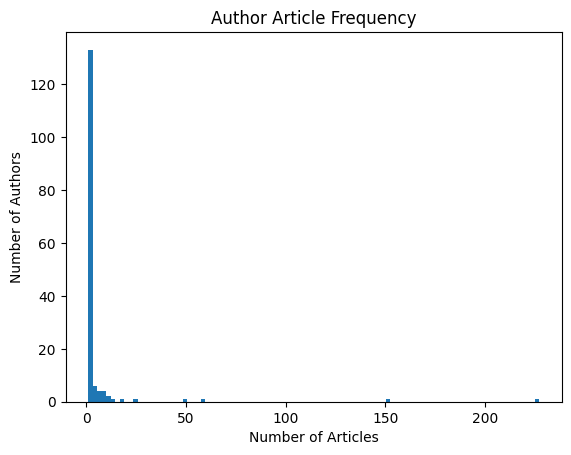

In [78]:
plt.hist(df['ORCID'].value_counts(), bins=100)
plt.title("Author Article Frequency")
plt.xlabel("Number of Articles")
plt.ylabel("Number of Authors")
plt.show()

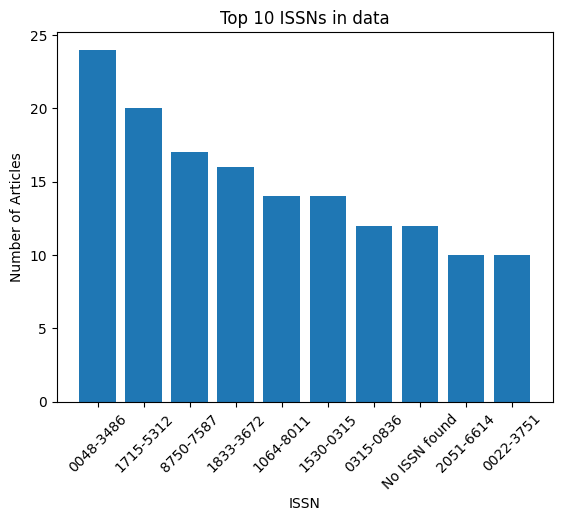

In [89]:
plt.bar(df['issn'].value_counts().index[:10], df['issn'].value_counts().values[:10])
plt.title("Top 10 ISSNs in data")
plt.ylabel("Number of Articles")
plt.xlabel("ISSN")
plt.xticks(rotation=45)
plt.show()

In [101]:
#Run to save as CSV
csv_file_name = "Brock_ORCID_Harvest_Start_Date_"+str(Start_Date)+"_to_"+datetime.today().strftime('%Y-%m-%d')+".csv"
print("Saving to file: "+csv_file_name)
df.to_csv(csv_file_name)
files.download(csv_file_name)

Saving to file: Brock_ORCID_Harvest_Start_Date_2025-01-01_to_2025-07-21.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Need to attend to

Some helper cells that will need to move somewhere more permanent.

In [ ]:
# Current ORCID list to csv
#b_members_df = pd.DataFrame(b_members)
#b_members_df.columns = ['ORCID']
#b_members_df.to_csv("ORCID_List.csv",index=False)
#files.download("ORCID_List.csv")